In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [17]:
# Try with 5 classes from selfmade dataset
import pathlib
data_dir = pathlib.Path().absolute()/'Images-23-classes'/'Images'
print(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

C:\Users\janlu\Documents\MALIS-bird-identification\Images-23-classes\Images
3057


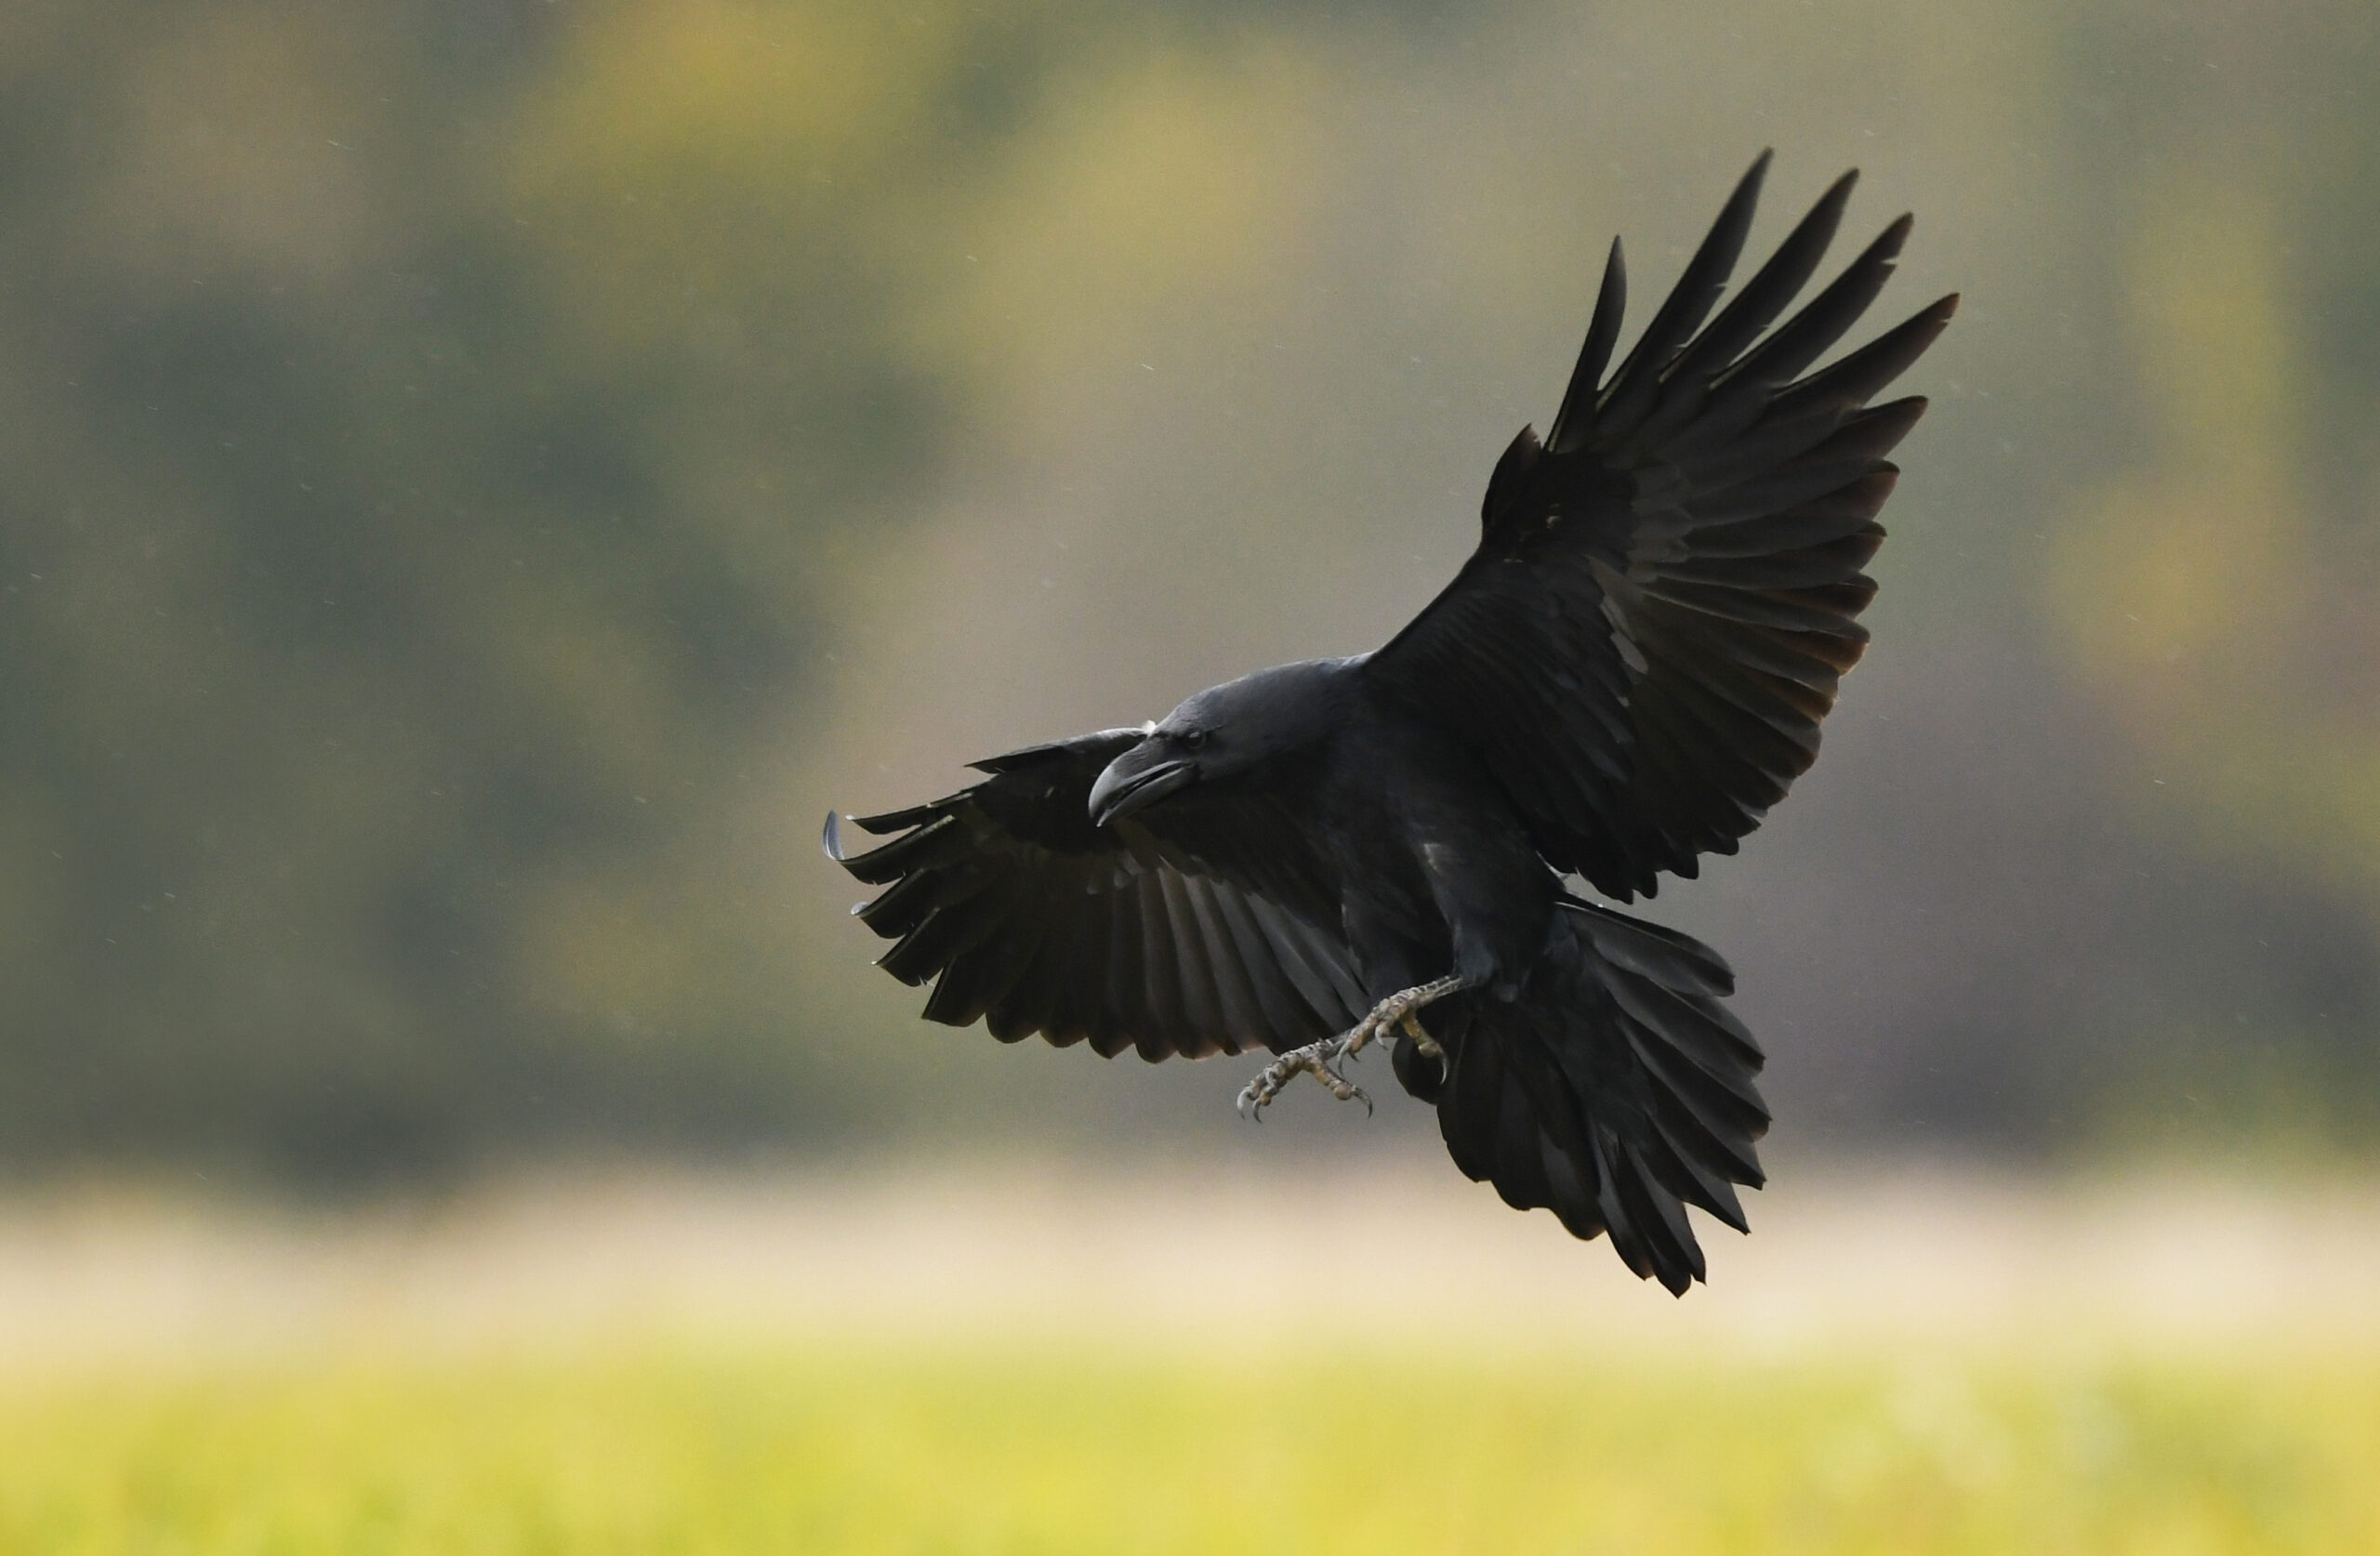

In [3]:
# Check first bird
crow = list(data_dir.glob('crow/*'))
PIL.Image.open(str(crow[0]))

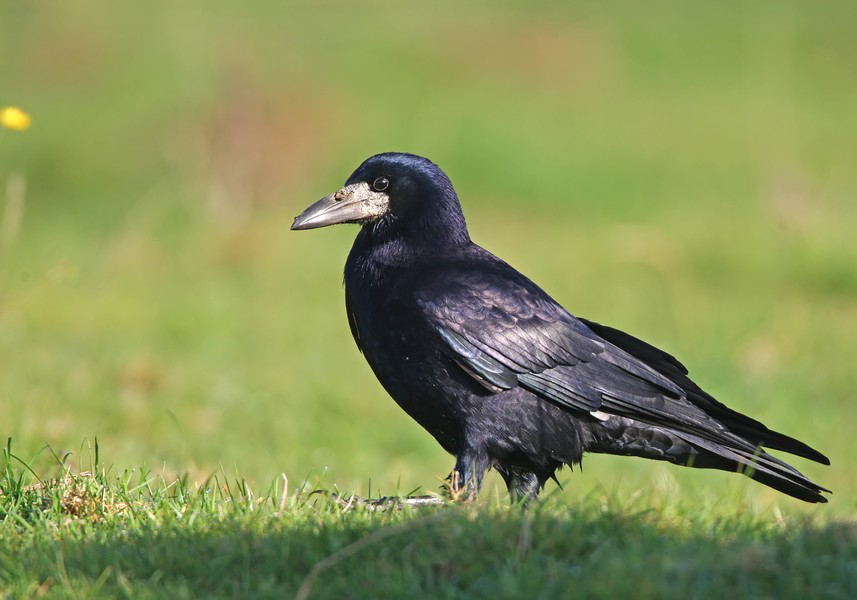

In [4]:
PIL.Image.open(str(crow[1]))

# Creating the Dataset

In [18]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 3068 files belonging to 23 classes.
Using 2455 files for training.
Found 3068 files belonging to 23 classes.
Using 613 files for validation.
['AFRICAN FIREFINCH', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'BALTIMORE ORIOLE', 'BLACK THROATED BUSHTIT', 'BORNEAN BRISTLEHEAD', 'COLLARED ARACARI', 'FLAMINGO', 'GOLDEN EAGLE', 'IMPERIAL SHAQ', 'KING VULTURE', 'KIWI', 'MANDRIN DUCK', 'PEACOCK', 'PINK ROBIN', 'PURPLE MARTIN', 'QUETZAL', 'RED HEADED WOODPECKER', 'SCARLET MACAW', 'SPLENDID WREN', 'WHITE CHEEKED TURACO', 'crow', 'seagull']


## Visualize the data


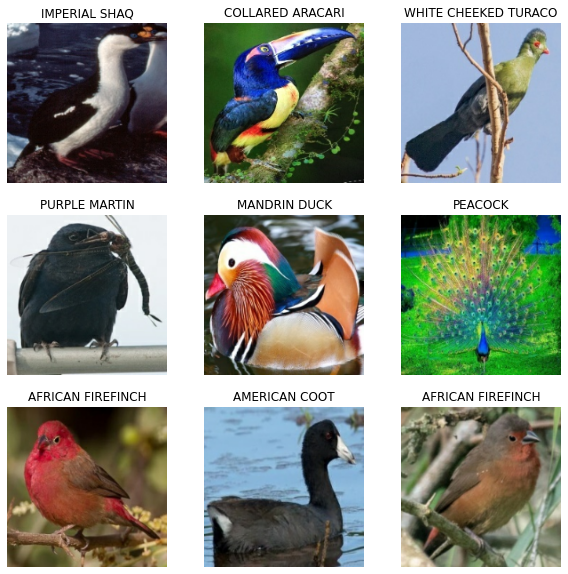

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [21]:
# Configuration

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



normalization_layer = layers.Rescaling(1./255)


normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


## Create model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

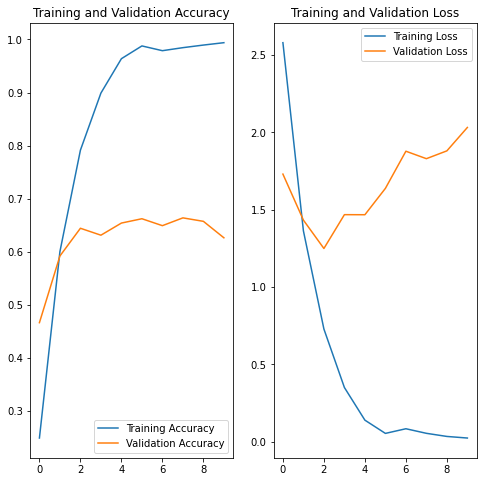

In [22]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


# Training

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data augmentation

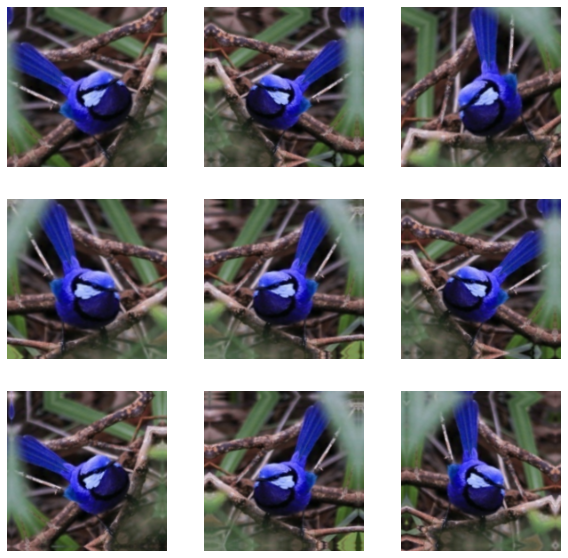

In [23]:
# Improve using ImageDataGenerator because just flipping does not work well enough

from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout -- do we need it? Testing

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## New model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [26]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
77/77 [==============================] - 52s 658ms/step - loss: 3.0017 - accuracy: 0.1088 - val_loss: 2.6482 - val_accuracy: 0.2398
Epoch 2/15
77/77 [==============================] - 50s 651ms/step - loss: 2.2213 - accuracy: 0.3458 - val_loss: 1.7632 - val_accuracy: 0.4763
Epoch 3/15
77/77 [==============================] - 52s 676ms/step - loss: 1.6174 - accuracy: 0.5234 - val_loss: 1.4299 - val_accuracy: 0.5775
Epoch 4/15
77/77 [==============================] - 46s 602ms/step - loss: 1.3419 - accuracy: 0.6024 - val_loss: 1.3474 - val_accuracy: 0.6183
Epoch 5/15
77/77 [==============================] - 45s 588ms/step - loss: 1.2035 - accuracy: 0.6395 - val_loss: 1.2030 - val_accuracy: 0.6460
Epoch 6/15
77/77 [==============================] - 49s 643ms/step - loss: 1.0563 - accuracy: 0.6912 - val_loss: 1.1737 - val_accuracy: 0.6705
Epoch 7/15
77/77 [==============================] - 49s 638ms/step - loss: 0.9306 - accuracy: 0.7185 - val_loss: 1.0833 - val_accuracy: 0.6770

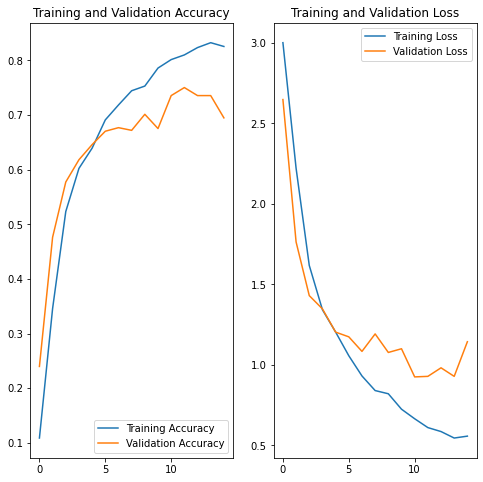

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Prediction test


In [29]:
crow_url = "https://image.forskning.no/188659.jpg?imageId=188659&width=706&height=484"
crow_path = tf.keras.utils.get_file('black_crow', origin=crow_url)

img = tf.keras.utils.load_img(crow_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to AMERICAN GOLDFINCH with a 78.39 percent confidence.


In [ ]:
# Very bad.